In [1]:
#Temperatur dependent defect document
# General
import numpy as np
import matplotlib.pyplot as plt
from eskild_function import *

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write
import os.path as osp

# For MD
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

In [12]:
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width parameter
length = 1            # periodic repetitions along z, i.e., transport direction here
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized using C.tersoff potential discussed below

ribbon = graphene_nanoribbon(n=n,
                             m=length,
                             type=kind,
                             C_C=bond,
                             vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)
# draw_atoms(ribbon)
structure = ribbon
eta = 0.001

--- Matrix Shapes ---
H_L: (5, 5)
H_D: (10, 10)
H_R: (5, 5)
t_L (Device-Left interface): (5, 5)
t_R (Device-Right interface): (5, 5)


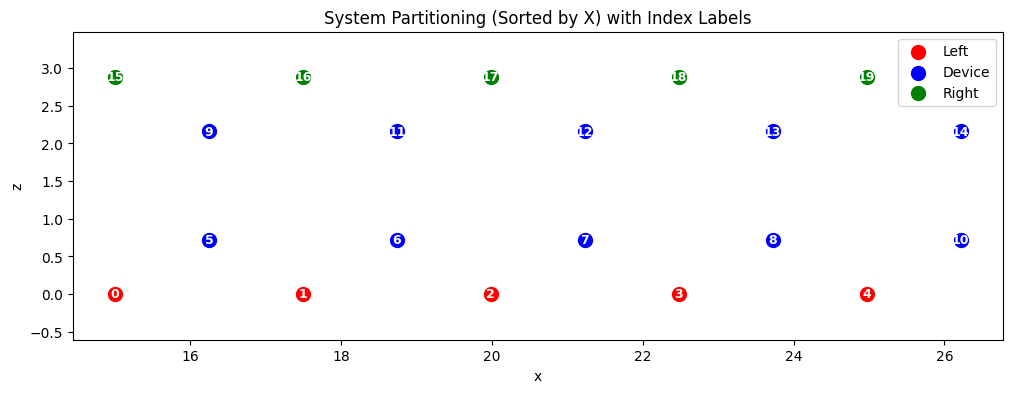

Number of atoms (and orbitals) in unit cell: 20


In [13]:
a = 1.42 # C-C bond length 

molecule = ribbon

#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 5

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(12, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()
Ntransport = 5 # number of repetitions in transport direction (z). To create simple [L|L|C|R|R] geometry.
pristine_structure = structure.repeat((1, 1, Ntransport))

natom_elec = len(structure)
print("Number of atoms (and orbitals) in unit cell:", natom_elec)



--- Matrix Shapes ---
H_L: (20, 20)
H_D: (60, 60)
H_R: (20, 20)
t_L (Device-Left interface): (20, 20)
t_R (Device-Right interface): (20, 20)


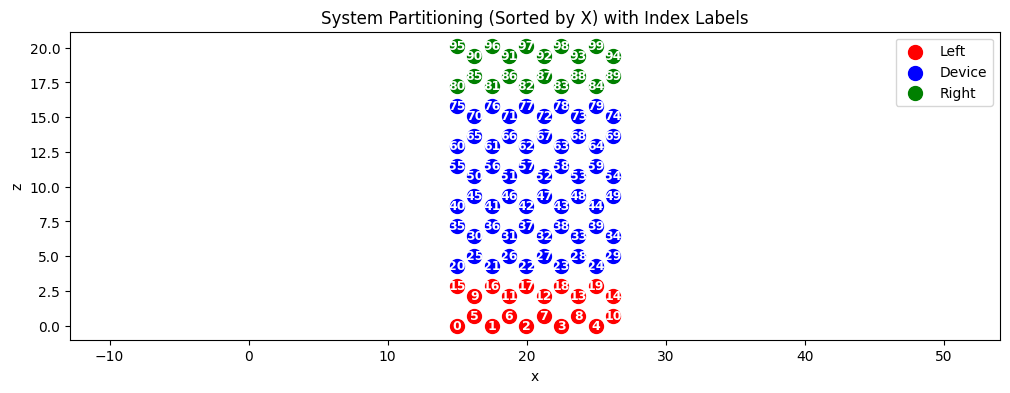

In [14]:
a = 1.42 # C-C bond length 

molecule = pristine_structure
#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 20

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(12, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


In [15]:
# --- Visualization of the Full Hamiltonian ---
import matplotlib.patches as patches

# Reconstruct the full sorted Hamiltonian for visualization
sorted_indices = np.concatenate([idx_L, idx_D, idx_R])
H_sorted = H_full[np.ix_(sorted_indices, sorted_indices)]

# # Use subplots to avoid figure collision and clearer control
# fig, ax = plt.subplots(figsize=(8, 8))

# # Use ax.matshow instead of plt.matshow
# cax = ax.matshow(H_sorted, cmap='bwr') 
# fig.colorbar(cax, label='Hamiltonian Value')
# ax.set_title("Full Hamiltonian Matrix (Sorted by X-position)")

# # Regions info
# NL = len(idx_L)
# ND = len(idx_D)
# NR = len(idx_R)
# start_D = NL
# start_R = NL + ND

# # Calculate boundaries for the lines
# boundary_1 = NL - 0.5
# boundary_2 = start_R - 0.5

# # Draw vertical lines (separating columns)
# ax.axvline(x=boundary_1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
# ax.axvline(x=boundary_2, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# # Draw horizontal lines (separating rows)
# ax.axhline(y=boundary_1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
# ax.axhline(y=boundary_2, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# # Label Diagonal Blocks
# # Centered in each block
# center_L = (NL - 1) / 2
# center_D = start_D + (ND - 1) / 2
# center_R = start_R + (NR - 1) / 2

# ax.text(center_L, center_L, 'H_L', color='black', ha='center', va='center', fontsize=12, fontweight='bold')
# ax.text(center_D, center_D, 'H_D', color='black', ha='center', va='center', fontsize=12, fontweight='bold')
# ax.text(center_R, center_R, 'H_R', color='black', ha='center', va='center', fontsize=12, fontweight='bold')

# # --- Highlight and Label the 4x4 Hopping Matrices ---
# # n_lead_atoms determines the size of the interface coupling
# vis_lead_size = n_lead_atoms 

# # 1. V_L (Coupling between L and D)
# # Located at intersection of D (rows) and L (cols) -> Bottom-Left of top-left cross
# # Rows: start of D to start of D + 4. Cols: 0 to 4.
# rect_VL = patches.Rectangle((-0.5, start_D - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
# ax.add_patch(rect_VL)
# ax.text(vis_lead_size/2 - 0.5, start_D + vis_lead_size/2 - 0.5, 'V_L', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# # 2. V_L dagger (Coupling between D and L) - Transpose of V_L
# # Rows: 0 to 4. Cols: start of D to start of D + 4.
# rect_VL_dag = patches.Rectangle((start_D - 0.5, -0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
# ax.add_patch(rect_VL_dag)
# ax.text(start_D + vis_lead_size/2 - 0.5, vis_lead_size/2 - 0.5, 'V_L†', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# # 3. V_R (Coupling between D and R)
# # Located at intersection of D (rows) and R (cols) -> Top-Right of bottom-right cross
# # Actually, t_R extracted previously connects D (rows) to R (cols)?
# # Let's assume standard chain: ... -> D -> R. 
# # Interaction is between END of D and START of R.
# # Rows: Last 4 of D. Cols: 0 to 4 of R (which is start_R to start_R+4)
# rect_VR = patches.Rectangle((start_R - 0.5, start_R - vis_lead_size - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
# ax.add_patch(rect_VR)
# ax.text(start_R + vis_lead_size/2 - 0.5, start_R - vis_lead_size/2 - 0.5, 'V_R', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# # 4. V_R dagger
# # Rows: 0 to 4 of R. Cols: Last 4 of D.
# rect_VR_dag = patches.Rectangle((start_R - vis_lead_size - 0.5, start_R - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
# ax.add_patch(rect_VR_dag)
# ax.text(start_R - vis_lead_size/2 - 0.5, start_R + vis_lead_size/2 - 0.5, 'V_R†', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# ax.set_xlabel("Atom Index (Sorted)")
# ax.set_ylabel("Atom Index (Sorted)")
# ax.grid(False) 
# plt.show()

In [16]:
#Parameters:
energy_range = np.linspace(-3,3, 200) * 2.7
epsilon = 0
eta = 0.0001
z = energy_range + 1j * eta

# We need to precompute self-energies first because transmission_vs_energy_one now expects them as lists
sig_L_list, g_surf_L_list = precompute_self_energies(energy_range, H_L, t_L, eta=0.0001)
sig_R_list, g_surf_R_list = precompute_self_energies(energy_range, H_R, t_R, eta=0.0001)

trans_val_perfect = transmission_vs_energy_one(H_D, energy_range, sig_R_list, sig_L_list, None, None, eta=0.0001)

In [17]:
#Giving atom 47 a on-site energy of -2 eV
H_defected = H_full.copy()
H_defected[47,47] = -2.0

In [18]:
#Parameters:
energy_range = np.linspace(-3,3, 200) * 2.7
epsilon = 0
eta = 0.0001
z = energy_range + 1j * eta

# Load parameter file
calc = Tersoff.from_lammps("C:\\Users\\eskil\\OneDrive\\DTU\\5.sem\\Quantum_Electronics\\C.tersoff")

# Set up calculator
structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = structure.get_potential_energy()
forces = structure.get_forces()

<AxesSubplot: xlabel='z, Å', ylabel='x, Å'>

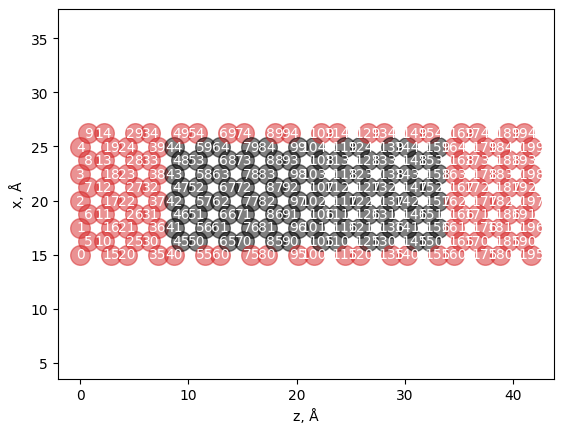

In [19]:
# First create longer [L|L|C|R|R] structure where L and R are fixed and the length of the central part (C) can be varied.
natoms_elec = len(structure)
xyz = structure.positions
lattice = structure.cell[:]
ntile = 10 # 
tiledir = 2 # tile in z
for n in range(1, ntile):
    xyz = np.concatenate((xyz, structure.positions + lattice[tiledir, :]*n))
tilemat = np.eye(3, dtype=int) # repetition matrix
tilemat[tiledir,tiledir] = ntile
lattice = tilemat @ lattice
natoms = len(xyz)
md_structure = Atoms(natoms*["C"], positions=xyz, cell=lattice, pbc=True) # Create a ASE atoms object of the repeated structure

# Fix electrode
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,natoms_elec*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-natoms_elec*fixed_uc,natoms)) # Fix the two last unit cells

# ... and edges to simplify MD
cutoff = 1.5 # Nearest neighbor distance is d0 = 1.43877067 Å
bulk_nneighbors = 3 # In bulk graphene there are 3 nearest neighbors

i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < bulk_nneighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

In [20]:
md_traj = read("md.xyz", index=":") # Load trajectory from xyz

In [ ]:
# --- Run the calculation ---
# Use every 2nd frame for speed
rad = md_traj[450:500:2]
sig_L_list, g_suf_L_list = precompute_self_energies(energy_range, H_L, t_L, eta=0.0001)
sig_R_list, g_suf_R_list = precompute_self_energies(energy_range, H_R, t_R, eta=0.0001)
list_defected = [99, 98, 97]
avg_list_defected = []
for i in list_defected:
    print(f"Calculating transmission for defect at atom {i}...")
    # Parallel calculation using the new defected function
    results_defected = Parallel(n_jobs=-1)(
        delayed(process_frame_defected)(frame, energy_range, sig_L_list, sig_R_list, 0.0001, [i], [-2.0]) 
        for frame in tqdm(rad))
    trans_list = results_defected
    avg_trans_defected = np.mean(trans_list, axis=0)
    avg_list_defected.append(avg_trans_defected)
    #Save avareged transmission to a file in CSV format into "TemperatureDependantTransport\Defected_tranmission_data" folder
    filename = f"Defected_tranmission_data\\Defected_tranmission_atom_{i}.csv"
    if osp.exists(filename) == False:
        print(f"File {filename} does not exist. Creating new file...")
        np.savetxt(filename, np.column_stack((energy_range / 2.7, avg_trans_defected)), delimiter=',', header='Energy(eV),Transmission', comments='')
    else:
        print(f"File {filename} exists. Wont overwrite.")

    

Calculating transmission for defect at atom 99...


  0%|          | 0/25 [00:00<?, ?it/s]

Calculating transmission for defect at atom 98...


  0%|          | 0/25 [00:00<?, ?it/s]

Calculating transmission for defect at atom 97...


  0%|          | 0/25 [00:00<?, ?it/s]

In [41]:
# #Plot
# fig, ax = plt.subplots(figsize=(10, 6))
# for defect_idx, transmission in zip(list_defected, avg_list_defected):
#     ax.plot(energy_range/2.7, transmission, label='Defect at atom {}'.format(defect_idx))
# ax.legend()
# ax.set_xlabel("Energy (eV)")
# ax.set_ylabel("Transmission")
# ax.set_title("Average Transmission vs Energy for Different Defect Positions")

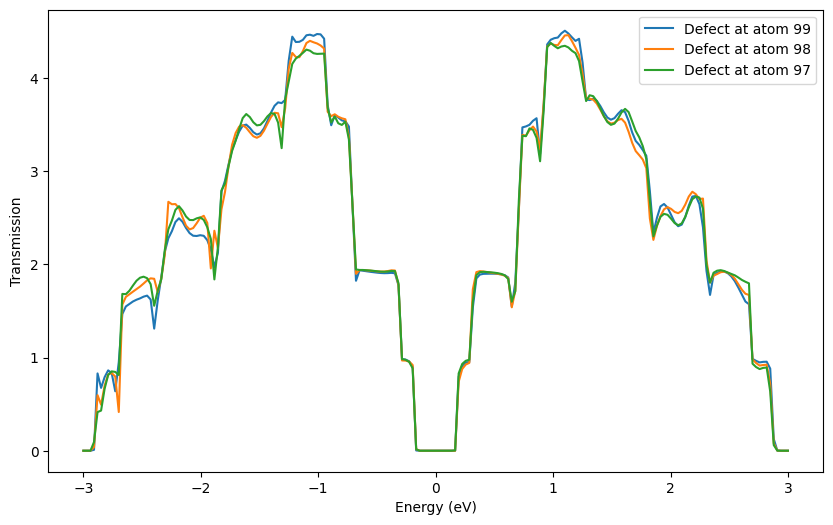

In [40]:
#Load data
data = []
for i in list_defected:
    # Skip the header row using skiprows=1
    data.append(np.loadtxt(f"Defected_tranmission_data\\Defected_tranmission_atom_{i}.csv", delimiter=',', skiprows=1))
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(data)):
    energy = data[i][:, 0]
    transmission = data[i][:, 1]
    ax.plot(energy, transmission, label='Defect at atom {}'.format(list_defected[i]))
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Transmission')
ax.legend()
plt.show()

In [ ]:
#Visualizing the current to the left with defects.
#J_nm = 1/hbar * Im[ H_nm * (A_L)_nm]
#Where A_L = G @ gamma_L @ G†